# Salary Predictions Based on Job Descriptions
***

# Part 1 - DEFINE

### ---- 1 Define the problem ----

This is a salary prediction problem.

The training set contains jobs where both job descriptions and salaries are available. The test set contains jobs where only job descriptions are available.

The objective is to learn from the information provided in the job description to predict the salary. 

The predicted salary can inform key decision makers when deciding on a prospective employee offer package. This predicted salary can also help with employee retention as company may lose their best employee to another employer who is willing to pay them more for the same job.

In [1]:
#import libraries

#computing libs
import pandas as pd
import numpy as np
import scipy as sp

#viz libs
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
%matplotlib inline

#ml libs
import sklearn as sk
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#other libs
import warnings
warnings.filterwarnings('ignore')

#info
__author__ = "Hieu Nguyen"
__email__ = "hieu.t.nguyen.aug25@gmail.com"

In [2]:
#helper functions

#load csv data files into a pandas df
def load_file(file):
    return pd.read_csv(file)

#examine the df
def examine(df):
    print(df.head())
    print('\n')
    print(df.info())

def isThisUnique(df, col):
    return df[col].duplicated().sum() == 0
    
#IQR calculator
def IQR_calculator(df, col, lower, upper):
    IQR = df[col].quantile(upper) - df[col].quantile(lower)
    return df[col].quantile(lower) - 1.5*IQR, df[col].quantile(upper) + 1.5*IQR
    
#merge data
def merge_data(df1, df2, key):
    return df1.merge(df2, on = key)

#clean data function
def clean_data(df):
    #removes rows where salary equals to zero
    return df[df.salary > 0]

#encode category features as category data type function
def encode_category(df, cat_features):
    for cat_feature in cat_features:
        df[cat_feature] = df[cat_feature].astype('category')

#encode categorical variables with their group mean
def encode_label(df, col):
    cat_dict ={}
    cats = df[col].cat.categories.tolist()
    for cat in cats:
        cat_dict[cat] = df[df[col] == cat]['salary'].mean()   
    df[col] = df[col].map(cat_dict)

#create visualize_features function
def visualize_features(df, col, gb = 'salary'):
    plt.figure(figsize = (18,8))
    if df[col].dtype == 'int64':
        #if column is numeric, plot a boxplot and the relationship between this feature and salary
        plt.subplot(121)
        mean = df.groupby(col)[gb].mean()
        std = df.groupby(col)[gb].std()
        mean.plot()
        plt.ylabel(gb)
        plt.fill_between(range(len(std.index)), mean.values - std.values, mean.values + std.values, alpha = 0.1)
        plt.subplot(122)
        sns.boxplot(df[col])
    else:
        #if column is categorical, plot a boxplot of salary grouped by the category's values
        mean = df.groupby(col)[gb].mean()
        levels = mean.sort_values().index.tolist()
        df[col].cat.reorder_categories(levels, inplace=True)
        sns.boxplot(x = col, y = gb, data = df)
    plt.ylabel(gb)
    plt.show()

#compare between train and test data by feature
def compare(train, test, col):
    df1 = pd.value_counts(train[col]).rename_axis(col).reset_index(name='Train')
    df2 = pd.value_counts(test[col]).rename_axis(col).reset_index(name='Test')
    df = df1.merge(df2, on = col)
    df['Diff'] = df['Train'] - df['Test']
    return df
    
#baseline model
def baseline_model(df, feature, kfolds):
    kf = KFold(n_splits = kfolds, shuffle = True, random_state = 44)
    mse = 0
    
    for i in range(kfolds):
        train_index, test_index = next(kf.split(df), None)
        train_fold, test_fold = df.iloc[train_index], df.iloc[test_index]
        baseline_salary = train_fold.groupby(feature).mean()
        baseline_predict = pd.merge(test_fold, baseline_salary, how = 'left', on = feature, 
                                    suffixes=('_actual', '_predicted'))
        mse += np.mean((baseline_predict['salary_actual'] - baseline_predict['salary_predicted'])**2)
    
    mse_baseline = mse/kfolds
    return mse_baseline

#feature engineering
def feature_engineering(df, advancedDegree = True, executives = True, seniorManagement = True, 
                        location = True, imputeAge = True, technical = True, onDemand = True):

    if advancedDegree:
        #create advancedDegree feature
        df['advancedDegree'] = 0
        df.loc[df['degree'] == 'MASTERS', 'advancedDegree'] = 1
        df.loc[df['degree'] == 'DOCTORAL', 'advancedDegree'] = 1
    
    if executives:
        #create executives feature
        df['executives'] = 0
        df.loc[df['jobType'] == 'CEO', 'executives'] = 1
        df.loc[df['jobType'] == 'CFO', 'executives'] = 1
        df.loc[df['jobType'] == 'CTO', 'executives'] = 1
        
    if seniorManagement: 
        #create seniorManagement feature
        df['seniorManagement'] = 0
        df.loc[df['jobType'] == 'SENIOR', 'seniorManagement'] = 1
        df.loc[df['jobType'] == 'MANAGER', 'seniorManagement'] = 1
        df.loc[df['jobType'] == 'VICE_PRESIDENT', 'seniorManagement'] = 1
          
    if location:
        #create city feature
        df['city'] = df['milesFromMetropolis'].apply(lambda x: 1 if x <= 10 else 0)

        #create suburb feature
        df['suburb'] = df['milesFromMetropolis'].apply(lambda x: 1 if (x > 10) and (x <= 50) else 0)

        #create rural feature
        df['rural'] = df['milesFromMetropolis'].apply(lambda x: 1 if x > 50 else 0)
        
    if imputeAge:
        #create imputedAge feature 
        df['imputedAge'] = 7 + df['yearsExperience']
        df.loc[df['degree'] == 'NONE', 'imputedAge'] += 11
        df.loc[df['degree'] == 'HIGH_SCHOOL', 'imputedAge'] += 12
        df.loc[df['degree'] == 'BACHELORS', 'imputedAge'] += 16
        df.loc[df['degree'] == 'MASTERS', 'imputedAge'] += 18
        df.loc[df['degree'] == 'DOCTORAL', 'imputedAge'] += 25
    
    if technical:
        #create technical feature
        df['technical'] = 0
        df.loc[df['major'] == 'ENGINEERING', 'technical'] = 1
        df.loc[df['major'] == 'BUSINESS', 'technical'] = 1
        
    if onDemand:
        #create onDemand feature
        df['onDemand'] = 0
        df.loc[(df['industry'] == 'OIL'), 'onDemand'] = 1
        df.loc[(df['industry'] == 'FINANCE'), 'onDemand'] = 1        
            
    return df, df.columns
    
def encode_dummies(df, cat_features):
    #produce dummy variables for categorical features
    cat_df = pd.get_dummies(df[cat_features])
    df = pd.concat([df, cat_df], axis=1)
    df = df.drop(cat_features, axis=1)
    return df

#train models
def train_model(model, train_cleaned_features, train_cleaned_target, cv_folds, mean_mse, cv_std):
    neg_mse = cross_val_score(model, train_cleaned_features, train_cleaned_target, 
                              cv = cv_folds, n_jobs = -1, scoring='neg_mean_squared_error')
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
    
#print summary
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

#choose best model
def choose_best_model(mean_mse):
    best_model = min(mean_mse, key = mean_mse.get)
    print('Best model:', best_model)
    print('\n')
    print('Best model Cross-validation MSE:', '{:.4f}'.format(mean_mse[best_model]))
    return best_model

#combine dummy features back together in feature importances    
def graph_feature_importances(model, feature_names, autoscale=True, headroom=0.1, width=18, summarized_columns=None):  
    feature_dict=dict(zip(feature_names, model.feature_importances_))
    for col_name in summarized_columns:
        sum_value = sum(x for i, x in feature_dict.items() if col_name in i )
        keys_to_remove = [i for i in feature_dict.keys() if col_name in i ]
        for i in keys_to_remove:
            feature_dict.pop(i)
        feature_dict[col_name] = sum_value
    results = pd.Series(feature_dict, index=feature_dict.keys())
    results.sort_values(inplace=True)
    print(results)
    results.plot(kind='barh', figsize=(width, len(results)))

#saves model, feature importances, predictions, and visualizations
def save_results(model, predictions, feature_importances):
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')

#produce a table of average salary, average years of experience, and count 
#of each category for a given categorical feature
def summarize_categorical(df, cat, sort_by = 'Mean Salary'):
    #calculate the mean salary by given categorical feature
    df1 = df.groupby([cat])['salary'].mean().reset_index(name = 'Mean Salary')

    #calculate the mean years of Experience by given categorical feature
    df2 = df.groupby([cat])['yearsExperience'].mean().reset_index(name = 'Mean Experience')

    #count the number of upper outliers by jobType
    df3 = df.groupby([cat])['salary'].count().reset_index(name = 'Count')
    return df1.join(df2.set_index(cat), on = cat).join(df3.set_index(cat), on = cat).sort_values(by = sort_by, ascending=False)

#produce a pivot table of average salary by pairs of features of choice
def ave_by(df, values = 'salary', index = 'yearsExperience', columns = 'industry'):
    return pd.pivot_table(df, values = values, index = index, columns = columns, aggfunc = np.mean)


## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [3]:
#load the data into Pandas dataframes
train_features = load_file("data/train_features.csv")
train_target = load_file("data/train_salaries.csv")
test_features = load_file("data/test_features.csv")

#### Examine the train_features df

In [4]:
examine(train_features)

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  
0   HEALTH               10                   83  
1      WEB                3                   73  
2   HEALTH               10                   38  
3     AUTO                8                   17  
4  FINANCE                8                   16  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
d

#### Examine the train_target df

In [5]:
examine(train_target)

              jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137
3  JOB1362684407690     142
4  JOB1362684407691     163


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
jobId     1000000 non-null object
salary    1000000 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.3+ MB
None


#### Examine the test_features df

In [6]:
examine(test_features)

              jobId companyId  jobType       degree    major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL     NONE   HEALTH   
1  JOB1362685407688    COMP13   JUNIOR         NONE     NONE     AUTO   
2  JOB1362685407689    COMP10      CTO      MASTERS  BIOLOGY   HEALTH   
3  JOB1362685407690    COMP21  MANAGER  HIGH_SCHOOL     NONE      OIL   
4  JOB1362685407691    COMP36   JUNIOR     DOCTORAL  BIOLOGY      OIL   

   yearsExperience  milesFromMetropolis  
0               22                   73  
1               20                   47  
2               17                    9  
3               14                   96  
4               10                   44  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major   

<a id = '3'></a>
### ---- 3 Clean the data ----

Data Cleaning:
- Found **jobId** to be a unique identifier for each row of data
- Merged train_features and train_target into a new train df
- Found no duplicates
- Found no missing or NaN
- Dropped 5 rows where salary is zero in the train set (out of a 1,000,000 rows)

#### Check for uniqueness of jobId

In [7]:
#is jobId unique?
print('test_features: ',isThisUnique(test_features,'jobId'))
print('train_target: ',isThisUnique(train_target,'jobId'))
print('train_features: ',isThisUnique(train_features,'jobId'))

#is jobId the primary_key across train_features and train_target df
np.array_equal(train_features['jobId'], train_target['jobId'])

test_features:  True
train_target:  True
train_features:  True


True

#### Merge the train_target and train_features df by jobId

In [8]:
train = merge_data(train_features, train_target, 'jobId')
examine(train)

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83     130  
1      WEB                3                   73     101  
2   HEALTH               10                   38     137  
3     AUTO                8                   17     142  
4  FINANCE                8                   16     163  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object


#### Count the number of duplicated rows

In [9]:
print('train df: ',train.duplicated().sum())
print('test_features df: ',test_features.duplicated().sum())

train df:  0
test_features df:  0


#### Count the total of NA

In [10]:
train.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [11]:
test_features.isna().sum()

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
dtype: int64

#### Looking for outliers salaries in the train df using the IQR rule

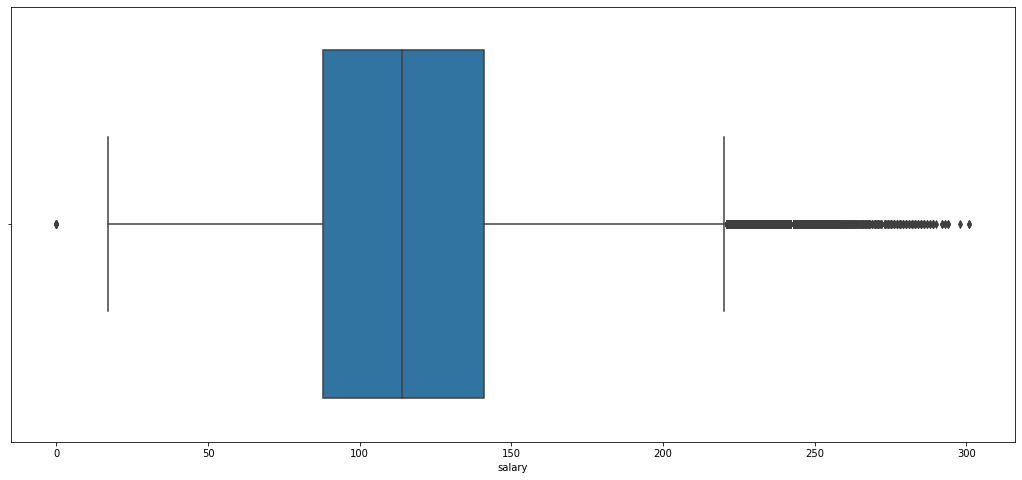

In [12]:
plt.figure(figsize = (18,8))
sns.boxplot(train.salary)
plt.show()

In [13]:
lower_whisker, upper_whisker = IQR_calculator(train, 'salary', 0.25, 0.75)

#### Outliers at the lower end

In [14]:
examine(train[train.salary < lower_whisker])

                   jobId companyId         jobType       degree        major  \
30559   JOB1362684438246    COMP44          JUNIOR     DOCTORAL         MATH   
495984  JOB1362684903671    COMP34          JUNIOR         NONE         NONE   
652076  JOB1362685059763    COMP25             CTO  HIGH_SCHOOL         NONE   
816129  JOB1362685223816    COMP42         MANAGER     DOCTORAL  ENGINEERING   
828156  JOB1362685235843    COMP40  VICE_PRESIDENT      MASTERS  ENGINEERING   

       industry  yearsExperience  milesFromMetropolis  salary  
30559      AUTO               11                    7       0  
495984      OIL                1                   25       0  
652076     AUTO                6                   60       0  
816129  FINANCE               18                    6       0  
828156      WEB                3                   29       0  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 30559 to 828156
Data columns (total 9 columns):
jobId                  5

**Comment**: Salary equals to zero does not make sense. The salary information in these rows is likely incorrectly recorded.

#### Outliers at the upper end

In [15]:
examine(train[train.salary > upper_whisker])

                jobId companyId         jobType    degree    major industry  \
266  JOB1362684407953    COMP30             CEO   MASTERS  BIOLOGY      OIL   
362  JOB1362684408049    COMP38             CTO   MASTERS     NONE   HEALTH   
560  JOB1362684408247    COMP53             CEO   MASTERS  BIOLOGY      WEB   
670  JOB1362684408357    COMP26             CEO   MASTERS     MATH     AUTO   
719  JOB1362684408406    COMP54  VICE_PRESIDENT  DOCTORAL  BIOLOGY      OIL   

     yearsExperience  milesFromMetropolis  salary  
266               23                   60     223  
362               24                    3     223  
560               22                    7     248  
670               23                    9     240  
719               21                   14     225  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7117 entries, 266 to 999893
Data columns (total 9 columns):
jobId                  7117 non-null object
companyId              7117 non-null object
jobType      

#### Breakdown outliers at the upper end by jobType

In [16]:
summarize_categorical(train[train.salary > upper_whisker], 'jobType', sort_by = 'Mean Salary')

,jobType,Mean Salary,Mean Experience,Count
0,CEO,235.938953,19.475984,3227
2,CTO,233.889113,20.129704,1488
1,CFO,233.816845,20.348930,1496
6,VICE_PRESIDENT,232.325041,20.842454,603
4,MANAGER,231.566820,21.364055,217
5,SENIOR,229.196970,22.257576,66
3,JUNIOR,227.800000,22.750000,20


**Comment**: Many of these upper outliers are executives and senior level staffs with many years of experience. This situation is to be expected in salary data. The most suspicious group are those who held Junior roles.

#### Look for upper outliers in salary who held Junior roles

In [17]:
train[(train.salary > upper_whisker) & (train.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


**Comment**: These upper outliers who held Junior roles are all located in the Finance and Oil industry. They have many years of experience on the job. Moreover, many of them also held terminal degrees in Business or Engineering. Their high salary is to be expected.

#### Data cleaning decision: 
Do not drop any of the upper outliers. Drop rows where salary is zero (5 rows to be dropped)

In [18]:
train_cleaned = clean_data(train)

### ---- 4 Explore the data (EDA) ----

In [19]:
cat_features = ['companyId', 'jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']

In [20]:
encode_category(train_cleaned, cat_features)

#### Visualize the features

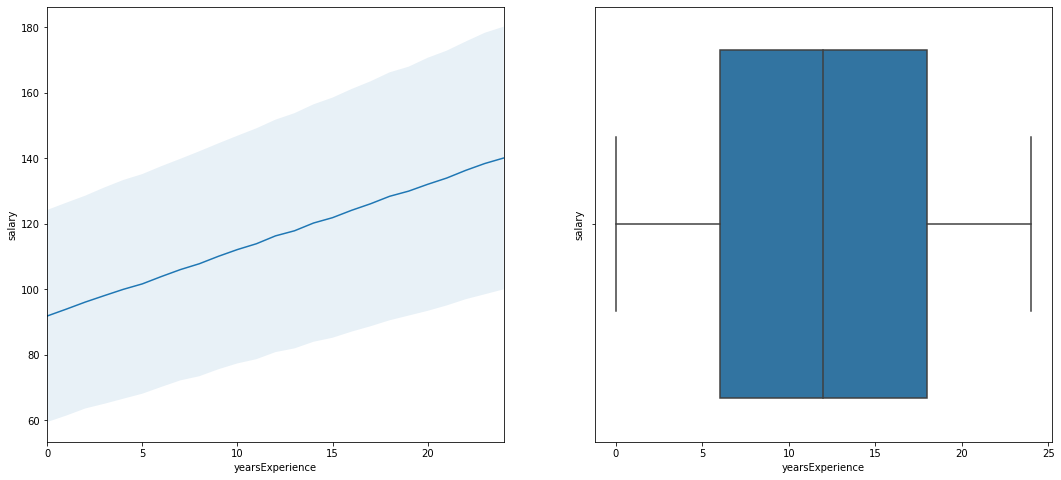

In [21]:
visualize_features(train_cleaned, 'yearsExperience')

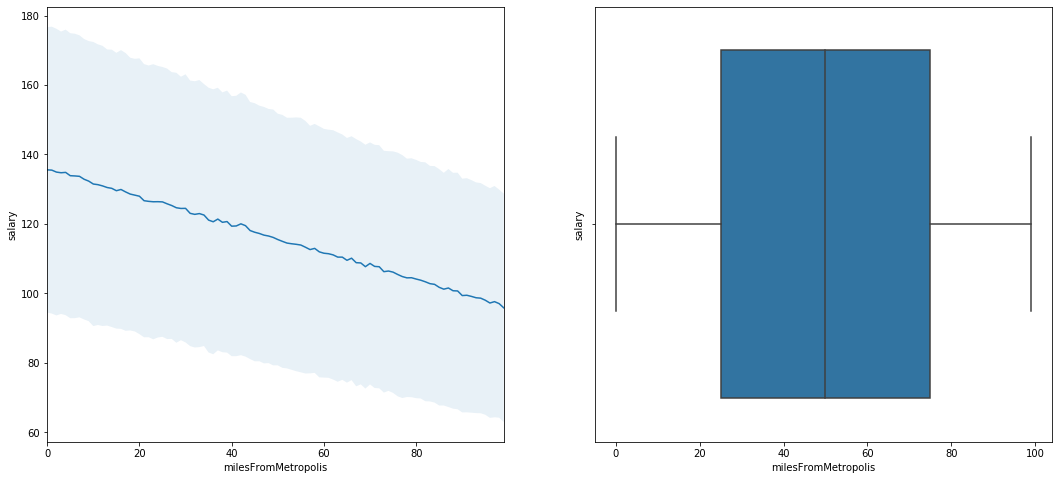

In [22]:
visualize_features(train_cleaned, 'milesFromMetropolis')

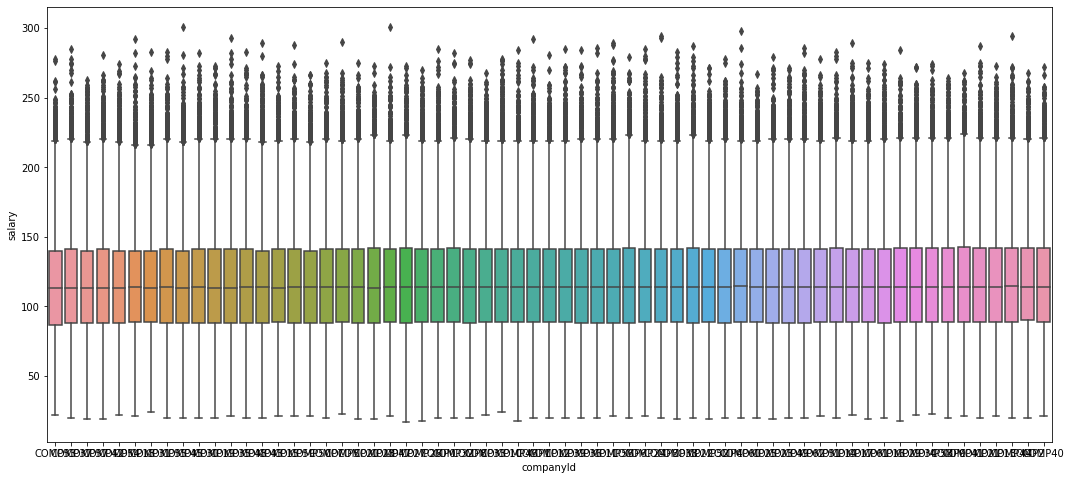

In [23]:
visualize_features(train_cleaned, 'companyId')

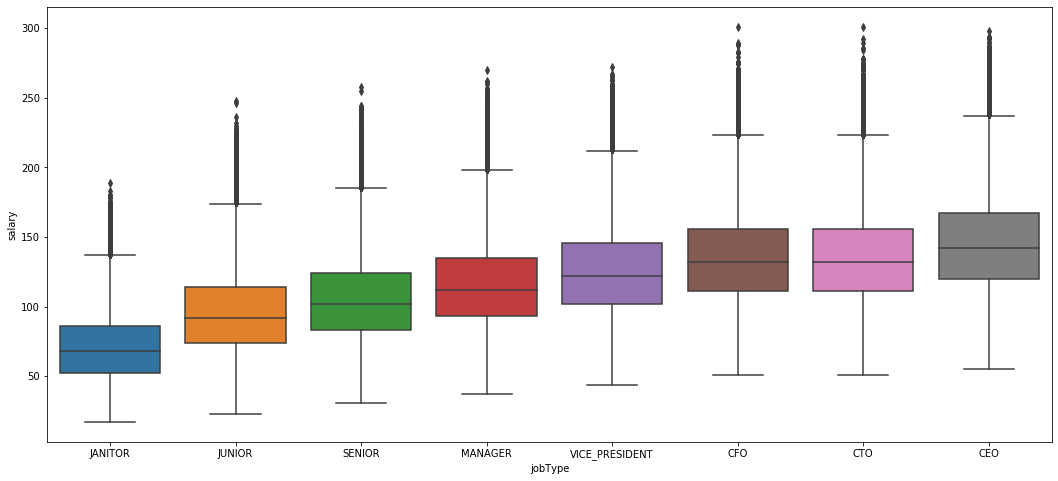

In [24]:
visualize_features(train_cleaned, 'jobType')

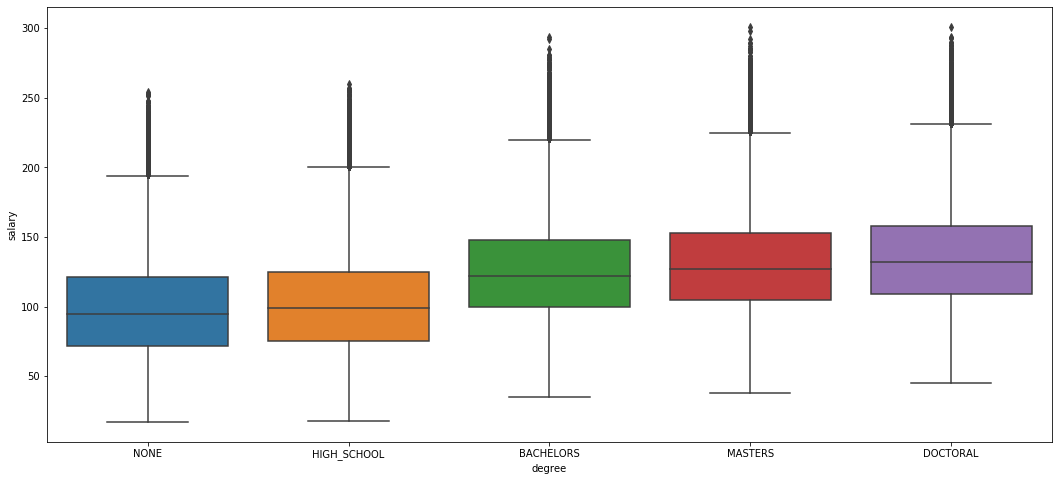

In [25]:
visualize_features(train_cleaned, 'degree')

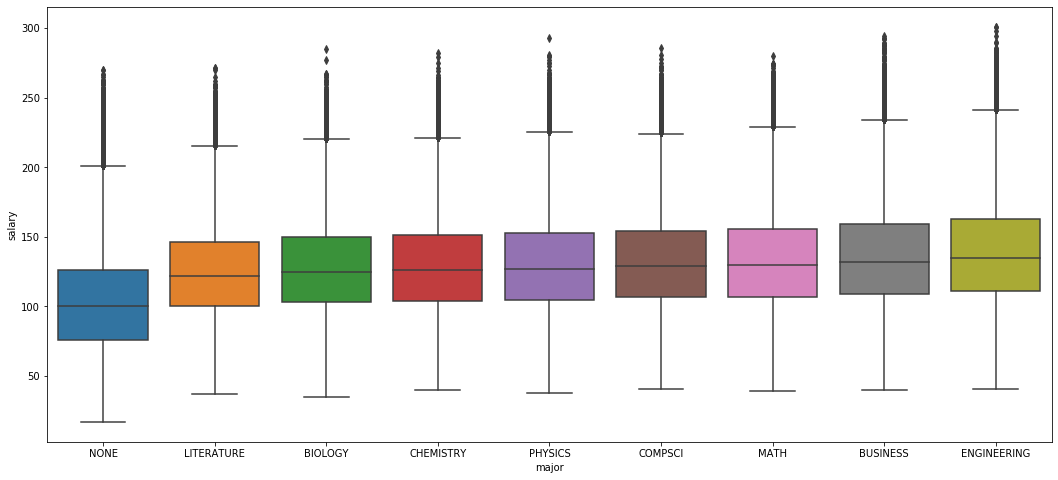

In [26]:
visualize_features(train_cleaned, 'major')

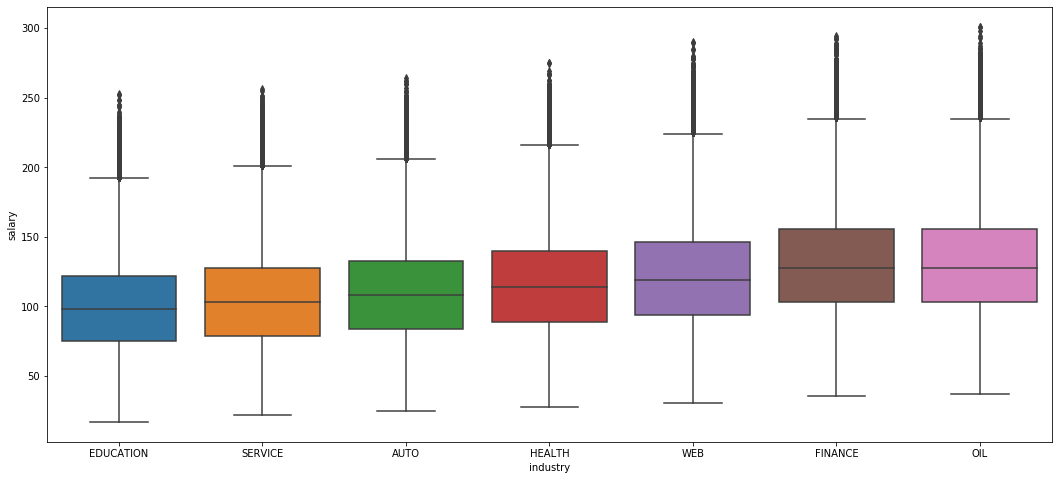

In [27]:
visualize_features(train_cleaned, 'industry')

#### Visualize the cleaned target variable

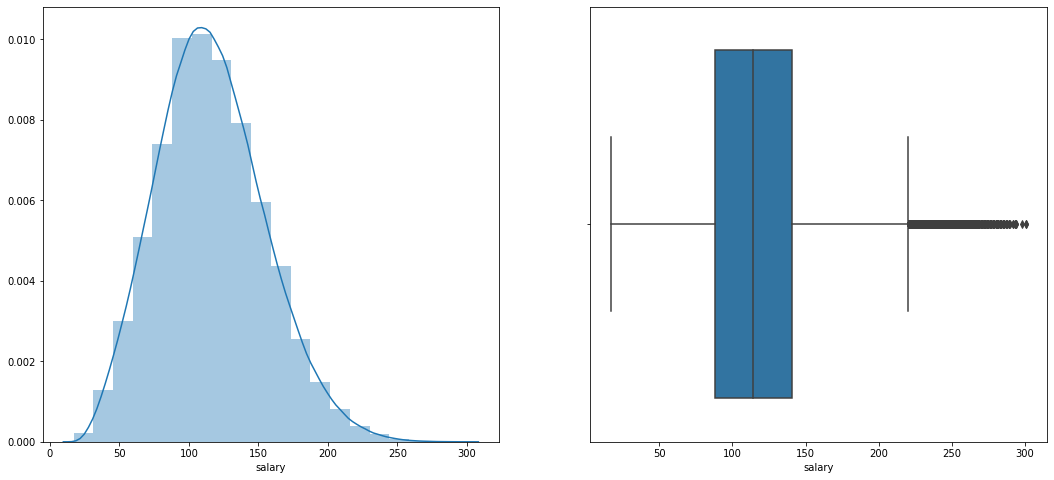

In [28]:
plt.figure(figsize = (18,8))
plt.subplot(121)
sns.distplot(train_cleaned.salary, bins = 20)
plt.subplot(122)
sns.boxplot(train_cleaned.salary)
plt.show()

In [29]:
train_cleaned['salary'].describe()

count    999995.000000
mean        116.062398
std          38.717163
min          17.000000
25%          88.000000
50%         114.000000
75%         141.000000
max         301.000000
Name: salary, dtype: float64

In [30]:
sp.stats.skew(train_cleaned.salary)

0.3465267592829531

**Comment**: The raw salary is positively skewed but the skewness is very minor. Since the magnitude of the skewness is less than 0.5, this distribution is considered to be approximately symmetric. 

This means we can keep the upper outliers in the dataset since keeping them do not skew the distribution of our target variable in a major way.

#### Visualize correlation between features and target variables

In [31]:
train_cleaned_encoded = train_cleaned.copy()
for col in train_cleaned_encoded.columns:
    if train_cleaned_encoded[col].dtype.name == "category":
        encode_label(train_cleaned_encoded, col)

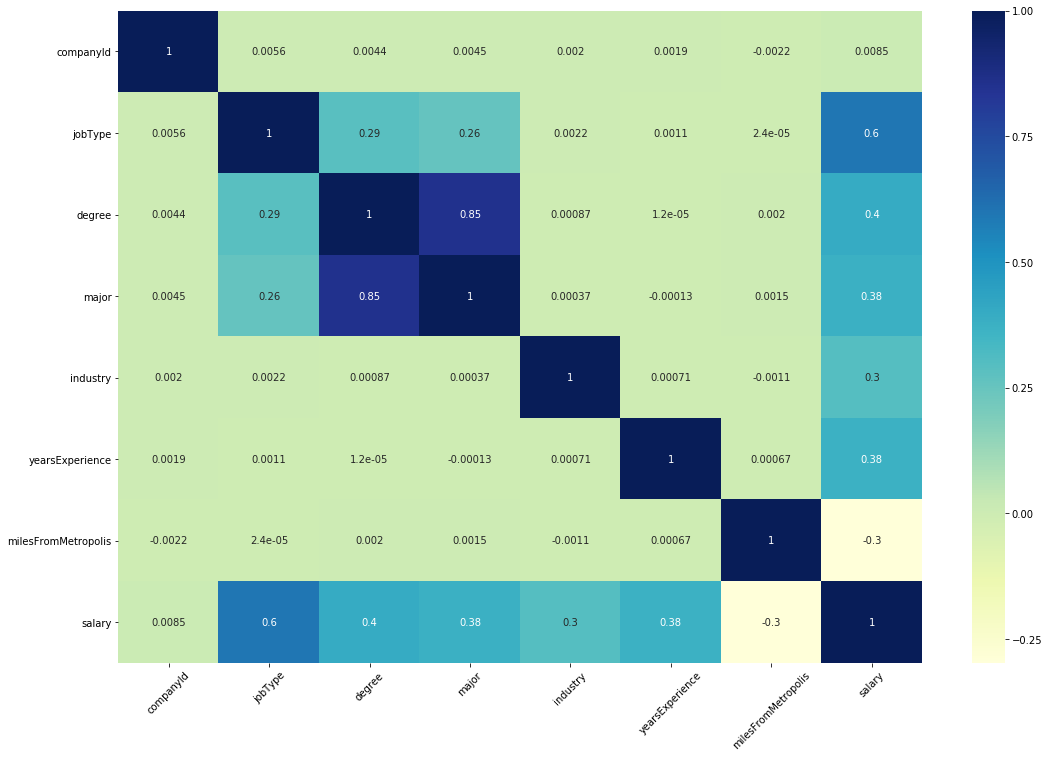

In [32]:
fig = plt.figure(figsize=(18, 12))
sns.heatmap(train_cleaned_encoded[cat_features + num_features + ['salary']].corr(), cmap='YlGnBu', annot=True)
plt.xticks(rotation=45)
plt.show()

### ---- 5 Establish a baseline ----

Since salary is a numerical and continuous variable. The metric used here is Mean squared error (MSE) measured during 5-fold cross-validation.

In this baseline model, we will use the average mean salary for each job type as the predicted salary.

In [33]:
print('Baseline Model MSE performance: ', baseline_model(train_cleaned, 'jobType', 5))

Baseline Model MSE performance:  965.3586899392845


### ---- 6 Hypothesize solution ----

Three models will be trained:
- Linear Regression
- Random Forest Regression
- Gradient Boosting Regression

New features to be engineered:
- **Dummy** features for categorical features: 
    + jobType, 
    + degree, 
    + major, 
    + industry
- **imputedAge**, which assumes about each individual:
    + the individual's age is equals to years of education plus years of experience plus 7
    + the individual starts his/her formal education when he/she turns 7
    + no unemployment during his/her career
    + Highschool = 12 yrs
    + Bachelor = 16 yrs
    + Master's = 18 yrs
    + Doctoral = 25 yrs
    + For degree = None cases, the individual's imputed age will be 7 plus years of experience plus assumed 11 yrs
- **executives**, a dummy feature which equals to 
    + 1 if jobType is CFO, CTO, or CEO, and 
    + 0 otherwise
- **seniorManagement**, a dummy feature which equals to 
    + 1 if jobType is Senior, Manager, or Vice President, and 
    + 0 otherwise
- **technical**, a dummy feature which equals to 
    + 1 if major is Engineering or Business, and 
    + 0 otherwise
- **onDemand**, a dummy feature which equals to 
    + 1 if industry is Oil or Finance, and 
    + 0 otherwise
- **city**, a dummy feature which equals to 
    + 1 if the distance from metropolis is less than 10 miles
- **suburb**, a dummy feature which equals to 
    + 1 if the distance from metropolis is between 10 miles and 50 miles
- **rural**, a dummy feature which equals to 
    + 1 if the distance from metropolis is greater than 50 miles

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [34]:
#cleaned train set before feature engineering
train_cleaned.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [35]:
#removing companyId as a categorical feature, see EDA for detail
cat_features = ['jobType', 'degree', 'major', 'industry']
num_features = ['yearsExperience', 'milesFromMetropolis']

#separate target
train_cleaned_target = train_cleaned.salary

#create train features df
train_cleaned_features = train_cleaned[num_features + cat_features]

#feature engineering
train_cleaned_features, summarized_columns = feature_engineering(train_cleaned_features)

#encode dummies
train_cleaned_features = encode_dummies(train_cleaned_features, cat_features)

#cleaned train features set after feature engineering
train_cleaned_features.head()

,yearsExperience,milesFromMetropolis,advancedDegree,executives,seniorManagement,city,suburb,rural,imputedAge,technical,...,major_MATH,major_BUSINESS,major_ENGINEERING,industry_EDUCATION,industry_SERVICE,industry_AUTO,industry_HEALTH,industry_WEB,industry_FINANCE,industry_OIL
0,10,83,1,1,0,0,0,1,35,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,0,1,0,0,0,1,22,0,...,0,0,0,0,0,0,0,1,0,0
2,10,38,1,0,1,0,1,0,42,0,...,0,0,0,0,0,0,1,0,0,0
3,8,17,1,0,1,0,1,0,40,0,...,0,0,0,0,0,1,0,0,0,0
4,8,16,0,0,1,0,1,0,31,0,...,0,0,0,0,0,0,0,0,1,0


In [36]:
train_cleaned_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999995 entries, 0 to 999999
Data columns (total 40 columns):
yearsExperience           999995 non-null int64
milesFromMetropolis       999995 non-null int64
advancedDegree            999995 non-null int64
executives                999995 non-null int64
seniorManagement          999995 non-null int64
city                      999995 non-null int64
suburb                    999995 non-null int64
rural                     999995 non-null int64
imputedAge                999995 non-null int64
technical                 999995 non-null int64
onDemand                  999995 non-null int64
jobType_JANITOR           999995 non-null uint8
jobType_JUNIOR            999995 non-null uint8
jobType_SENIOR            999995 non-null uint8
jobType_MANAGER           999995 non-null uint8
jobType_VICE_PRESIDENT    999995 non-null uint8
jobType_CFO               999995 non-null uint8
jobType_CTO               999995 non-null uint8
jobType_CEO              

### ---- 8 Create models ----

In [37]:
#initialize models
lr = LinearRegression()
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()

#containers
models = []
mean_mse = {}
cv_std = {}

### Tune models' hyperparameters

#### Tune hyperparameters for Random Forest Regressor

1 depth
The OOB Score is: 0.1113328620369437
 
2 depth
The OOB Score is: 0.2737664126715794
 
3 depth
The OOB Score is: 0.38773532641504904
 
4 depth
The OOB Score is: 0.45344545515321044
 
5 depth
The OOB Score is: 0.498497832356007
 
10 depth
The OOB Score is: 0.6166688681400851
 
20 depth
The OOB Score is: 0.6103687601999528
 


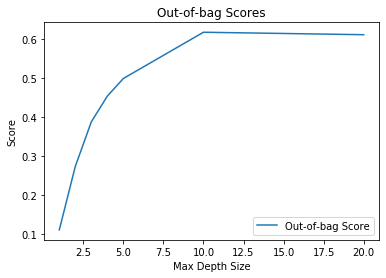

In [51]:
oob_scores  =  []
max_depth_size  = [1, 2, 3, 4, 5, 10, 20]

for depth in max_depth_size:
    model = RandomForestRegressor(max_depth=depth, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(depth, 'depth')
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")

plt.plot(max_depth_size, oob_scores, label='Out-of-bag Score')
plt.xlabel('Max Depth Size')
plt.ylabel('Score')
plt.title('Out-of-bag Scores')
plt.legend(loc="lower right")
plt.show()

1 trees
The OOB Score is: -5.486567750281481
 
2 trees
The OOB Score is: -3.2595535878544917
 
3 trees
The OOB Score is: -1.8450997897569956
 
4 trees
The OOB Score is: -0.9435440221136313
 
5 trees
The OOB Score is: -0.36947597548423494
 
15 trees
The OOB Score is: 0.6591149131117711
 
20 trees
The OOB Score is: 0.678699574983406
 
25 trees
The OOB Score is: 0.6853908393130376
 
40 trees
The OOB Score is: 0.6936266016606256
 
50 trees
The OOB Score is: 0.6962557438859045
 


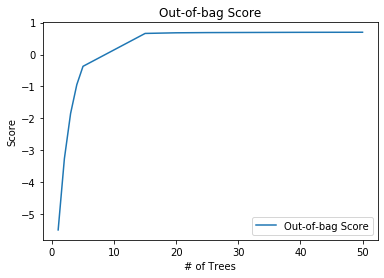

In [52]:
oob_scores = []
n_estimator_options = [1, 2, 3, 4, 5, 15, 20, 25, 40, 50]

for trees in n_estimator_options:
    model = RandomForestRegressor(n_estimators = trees, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(trees, 'trees')
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")
    
plt.plot(n_estimator_options, oob_scores, label='Out-of-bag Score')
plt.xlabel('# of Trees')
plt.ylabel('Score')
plt.title('Out-of-bag Score')
plt.legend(loc="lower right")
plt.show()

1 min samples
The OOB Score is: 0.5488779430980624
 
2 min samples
The OOB Score is: 0.5862637677266365
 
3 min samples
The OOB Score is: 0.6051526495683867
 
4 min samples
The OOB Score is: 0.6164541063113667
 
5 min samples
The OOB Score is: 0.6236377555577788
 
6 min samples
The OOB Score is: 0.6287226400260215
 
7 min samples
The OOB Score is: 0.6326771004022125
 
8 min samples
The OOB Score is: 0.6354982884117468
 
9 min samples
The OOB Score is: 0.6377958512247832
 
10 min samples
The OOB Score is: 0.639742773422624
 
20 min samples
The OOB Score is: 0.6480969525026067
 


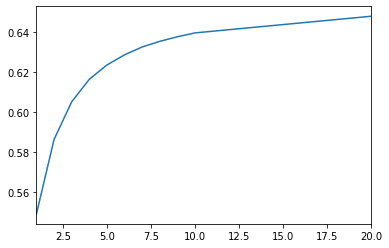

In [55]:
oob_scores = []
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20]

for min_samples in min_samples_leaf_options:
    model = RandomForestRegressor(min_samples_leaf=min_samples, oob_score=True, n_jobs=-1, random_state=44)
    model.fit(train_cleaned_features, train_cleaned_target)
    print(min_samples, "min samples")
    oob = model.oob_score_
    print('The OOB Score is: ' + str(model.oob_score_))
    oob_scores.append(oob)
    print (" ")
    
pd.Series(oob_scores, min_samples_leaf_options).plot()
plt.show()

In [57]:
from sklearn.model_selection import GridSearchCV
param_grid = {"max_depth": [8,9,10,11],
              "min_samples_leaf" : [20,25,30],
              "n_estimators": [15,20,25]}

model = RandomForestRegressor()
gs_cv = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose=10, n_jobs=-1).fit(train_cleaned_features, train_cleaned_target)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 39.1min finished


In [58]:
#select best model
rf_tuned = gs_cv.best_estimator_
rf_tuned

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Tune hyperparameters for Gradient Boosting Regressor

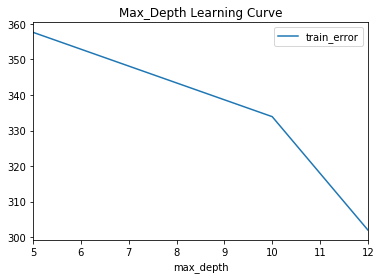

In [38]:
results = []

for depth in [5, 10, 12]:
    gbrt = GradientBoostingRegressor(max_depth = depth)
    gbrt.fit(train_cleaned_features, train_cleaned_target)
    results.append({'max_depth': depth,
                   'train_error': mean_squared_error(train_cleaned_target, gbrt.predict(train_cleaned_features))})

max_depth_lr = pd.DataFrame(results).set_index('max_depth').sort_index()
max_depth_lr.plot(title="Max_Depth Learning Curve")
plt.show()

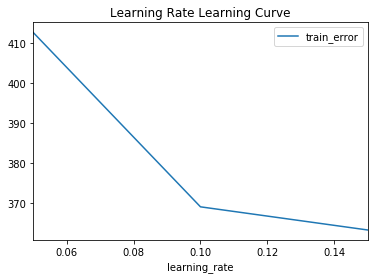

In [41]:
results = []

for rate in [0.05, 0.1, 0.15]:
    gbrt = GradientBoostingRegressor(learning_rate = rate)
    gbrt.fit(train_cleaned_features, train_cleaned_target)
    results.append({'learning_rate': rate,
                    'train_error': mean_squared_error(train_cleaned_target, gbrt.predict(train_cleaned_features)),})

learning_rate_lr = pd.DataFrame(results).set_index('learning_rate').sort_index()
learning_rate_lr.plot(title = 'Learning Rate Learning Curve')
plt.show()

### ---- 9 Test models ----

In [45]:
#detailed settings of tuned models
rf_tuned = RandomForestRegressor(bootstrap=True, max_depth=11, max_features='auto', max_leaf_nodes=None,
                                 min_samples_leaf=30, min_samples_split=2, n_estimators=25)

gbm_tuned = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, max_depth=5, max_features=None,
                                      max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150)

#add models to list
models.extend([lr, rf_tuned, gbm_tuned])

#train models
cv_folds = 5
for model in models:
    train_model(model, train_cleaned_features, train_cleaned_target, cv_folds, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)


Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4192961870642
Standard deviation during CV:
 1.7785312636468362

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Average MSE:
 402.48265242987645
Standard deviation during CV:
 1.9546860241444626

Model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_

### ---- 10 Select best model  ----

In [46]:
model = choose_best_model(mean_mse)

Best model: GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


Best model Cross-validation MSE: 357.2671


suburb                 0.000062
city                   0.000121
advancedDegree         0.000404
degree                 0.003075
technical              0.008488
rural                  0.009433
yearsExperience        0.033807
industry               0.049295
major                  0.051960
seniorManagement       0.054377
onDemand               0.066901
milesFromMetropolis    0.118909
jobType                0.171588
executives             0.198666
imputedAge             0.232914
dtype: float64


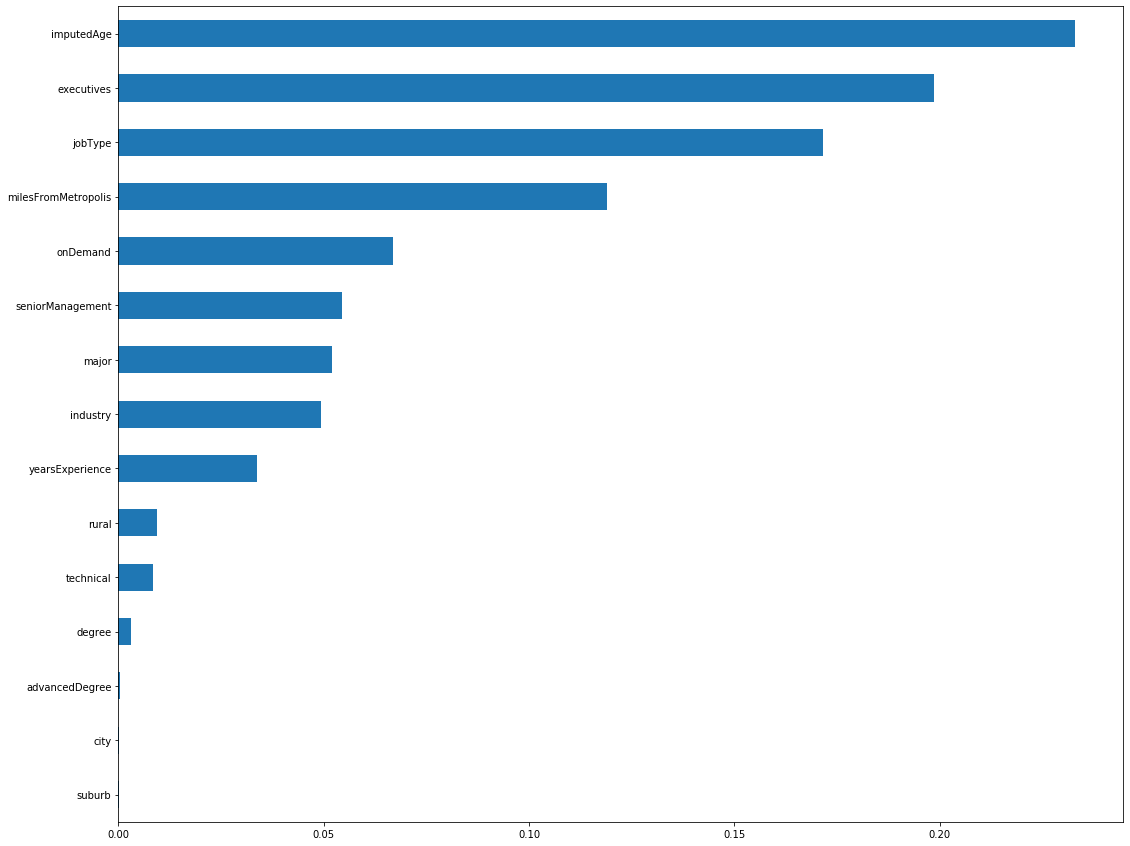

In [39]:
#fit best model on entire train df
model.fit(train_cleaned_features, train_cleaned_target)

#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(train_cleaned_features.columns)
    
feature_importances = pd.DataFrame({'feature':train_cleaned_features.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)

#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)
results = graph_feature_importances(model, train_cleaned_features.columns, summarized_columns = summarized_columns)

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [6]:
#write script that trains model on entire training set, saves model to disk, and scores the "test" dataset
def salary_prediction_pipeline(train_features_file, train_target_file, test_features_file, 
                               categorical_features_names, numerical_features_names):
    
    #load data
    print('Loading data...')
    train_features = load_file(train_features_file)
    train_target = load_file(train_target_file)
    test_features = load_file(test_features_file)
    
    #clean data
    print('Merging data...')
    train = merge_data(train_features, train_target, 'jobId')
    
    print('Clearning data...')
    '''Only the train df needs to be cleaned (dropping salaries below zero)'''
    train_cleaned = clean_data(train)
    
    print('Encoding categorical variables...')
    '''Only the helpful catergorical and numerical variables are included'''
    cat_features = categorical_features_names
    num_features = numerical_features_names
    encode_category(train_cleaned, cat_features)
    
    #separate cleaned train target
    print('Separating cleaned train target...')
    train_cleaned_target = train_cleaned.salary
    train_cleaned_features = train_cleaned[num_features + cat_features]
    
    #feature engineering
    print('Engineering Features for train dataset...')
    train_cleaned_features, summarized_columns = feature_engineering(train_cleaned_features)
    
    #encoding dummies
    print('Encoding dummies...')
    train_cleaned_features = encode_dummies(train_cleaned_features, cat_features)
    
    #initialize tuned models
    print('Initializing models...')
    lr = LinearRegression()
    rf = RandomForestRegressor(bootstrap=True, max_depth=11, max_features='auto', max_leaf_nodes=None,
                               min_samples_leaf=30, min_samples_split=2, n_estimators=25)
    gbm = GradientBoostingRegressor(alpha=0.9, learning_rate=0.1, max_depth=5, max_features=None,
                                    max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=150)

    #containers
    models = [lr, rf, gbm]
    mean_mse = {}
    cv_std = {}

    #train models under 5-fold cross-validation and selecting best model based on MSE
    print('Training models under 5-fold cross-validation...')
    cv_folds = 5
    for model in models:
        train_model(model, train_cleaned_features, train_cleaned_target, cv_folds, mean_mse, cv_std)
        print_summary(model, mean_mse, cv_std)
    print('Selecting best model on MSE...')
    model = choose_best_model(mean_mse)
    
    #train best model on entire train dataset
    print('Training best model on entire train dataset...')
    model.fit(train_cleaned_features, train_cleaned_target)
    predict = model.predict(train_cleaned_features)
    print('MSE of model prediction on entire train dataset: ', 
          '{:.4f}'.format(mean_squared_error(train_cleaned.salary, predict)))
    
    #create predictions based on test data
    print('Engineering features for test dataset...')
    encode_category(test_features, cat_features)
    test_features = test_features[num_features + cat_features]
    test_features, test_df_summarized_columns = feature_engineering(test_features)
    test_features = encode_dummies(test_features, cat_features)
    print('Creating predictions based on test dataset...')
    test_df_predictions = model.predict(test_features)
    
    #store features importances
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        #linear models don't have feature_importances_
        importances = [0]*len(train_cleaned_features.columns)
    feature_importances = pd.DataFrame({'feature':train_cleaned_features.columns, 'importance':importances})
    feature_importances.sort_values(by='importance', ascending=False, inplace=True)
    
    #group dummy features importances back together
    results = graph_feature_importances(model, train_cleaned_features.columns, 
                                        summarized_columns = summarized_columns)
    
    #save results to disk
    print('Saving model...')
    print('Saving prediction...')
    print('Saving feature importances...')
    save_results(model, test_df_predictions, results)
    
    #create visualizations
    print('Creating visualizations...')
    print('Saving visualizations...')
    with PdfPages('multipage_pdf.pdf') as pdf:
        #feature importances
        feature_importances_fig = graph_feature_importances(model, train_cleaned_features.columns, 
                                                            summarized_columns = summarized_columns)
        plt.title('Feature Importances in the train dataset.')
        pdf.savefig(feature_importances_fig)
        plt.close()

        predicted_salary_dist = plt.figure(figsize = (18,8))
        plt.subplot(121)
        sns.distplot(test_df_predictions, bins = 20)
        plt.subplot(122)
        sns.boxplot(test_df_predictions)
        plt.title('Predicted Salary Distribution.')
        pdf.savefig(predicted_salary_dist)
        plt.close()
    
    #finished
    print('Finished.')

### ---- 12 Deploy solution ----

In [7]:
salary_prediction_pipeline("data/train_features.csv", "data/train_salaries.csv", "data/test_features.csv", ['jobType', 'degree', 'major', 'industry'], ['yearsExperience', 'milesFromMetropolis'])

Loading data...
Merging data...
Clearning data...
Encoding categorical variables...
Separating cleaned train target...
Engineering Features for train dataset...
Encoding dummies...
Initializing models...
Training models under 5-fold cross-validation...

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 384.4192978836279
Standard deviation during CV:
 1.7785276698145402

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=30, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Average MSE:
 402.746816558794
Standard deviation during CV:
 2.071713289596382

Model:
 GradientBoosting

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data